In [ ]:
#Importing libraries
import pandas as pd
import numpy as np
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os
from os import listdir

import tensorflow as tf

import tensorflow_datasets as tfds

from keras import layers

import random

Mounted at /content/drive


In [ ]:
# import required libraries
import numpy as np
import cv2
from matplotlib import pyplot as plt

# read two input images as grayscale images
imgL = cv2.imread('/content/drive/MyDrive/Capsule Endoscopy/labelled_images/Polyp/131368cc17e44240_28974.jpg',0)
imgR = cv2.imread('/content/drive/MyDrive/Capsule Endoscopy/labelled_images/Polyp/131368cc17e44240_28974.jpg',0)

# Initiate and StereoBM object
stereo = cv2.StereoBM_create(numDisparities=16, blockSize=15)

# compute the disparity map
disparity = stereo.compute(imgL,imgR)
plt.imshow(disparity,'gray')
plt.show()
disparity.shape

error: ignored

In [ ]:
folder_dir = "/content/drive/MyDrive/Capsule Endoscopy/labelled_images"
categories = ["Ampulla of vater", "Angiectasia", "Blood - fresh", "Blood - hematin", "Erosion", "Erythema", "Foreign body", "Ileocecal valve", "Lymphangiectasia", "Normal clean mucosa 2", "Polyp", "Pylorus", "Reduced mucosal view", "Ulcer"]

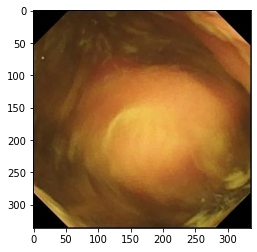

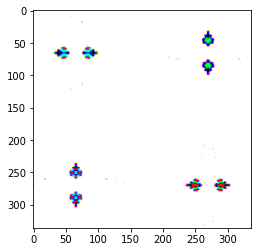

In [ ]:
img_array = cv2.imread('/content/drive/MyDrive/Capsule Endoscopy/labelled_images/Polyp/131368cc17e44240_29005.jpg')
image = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)

pixels = np.array(image)

plt.imshow(pixels)
plt.show()

IMG_SIZE = 180

resize_and_rescale = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"), layers.RandomRotation(0.2), layers.RandomZoom(0.9)
])

result = resize_and_rescale(image)
_ = plt.imshow(result)

Training Data

  0%|          | 2/906 [00:01<13:40,  1.10it/s]


KeyboardInterrupt: ignored

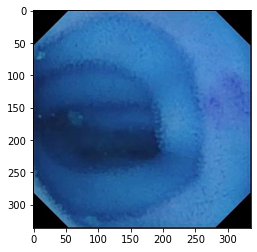

In [ ]:
import tqdm

training_data = []
class_nums = []

data_augmentation = tf.keras.Sequential([layers.RandomFlip("horizontal_and_vertical"), layers.RandomRotation(0.2), layers.RandomZoom(0.9),])

def create_training_data():
  for folders in categories:
    counter = 0
    path = os.path.join(folder_dir, folders)
    class_num = categories.index(folders)
    for img in tqdm.tqdm(np.random.permutation(os.listdir(path))):
      if counter > 5000:
        break

      img_array = cv2.imread(os.path.join(path, img))
      new_array = cv2.resize(img_array, (50, 50))
      training_data.append(new_array)

      class_nums.append(class_num)
      counter += 1

      new_augmented_array = data_augmentation(new_array)
      training_data.append(new_augmented_array)
      class_nums.append(class_num)
      #counter += 1


create_training_data()

CNN Model

In [ ]:
training_data = np.array(training_data)
#categories = np.array(class_nums)
#categories = np.unique(categories)

#import random

#random.shuffle(training_data)

In [ ]:
X = []
y = np.zeros(shape=[training_data.shape[0], len(categories)])

for features in training_data:
  X.append(features)

for i, label in enumerate(class_nums):
  y[i, label]=1



X = np.array(X)
y = np.array(y)

print(X.shape)
print(y.shape)

print(y)

#X = np.array(X).reshape(-1, 50, 50, 3)
#y = np.array(y).reshape(-1, 50, 50, 1)

(35896, 50, 50, 3)
(35896, 14)
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [ ]:
import pickle
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D

X = pickle.load(open("X.pkl", "rb"))
y = pickle.load(open("y.pkl", "rb"))

X = X/255.0

#y = np.array(y).reshape(1,-1)

data_augmentation = tf.keras.Sequential([layers.RandomFlip("horizontal_and_vertical"), layers.RandomRotation(0.2), layers.RandomZoom(0.9),])

def create_model():
  model = Sequential()
  model.add(Conv2D(64, (3,3), input_shape = X.shape[1:]))
  model.add(Activation("relu"))

  model.add(Conv2D(64, (3,3)))
  model.add(Activation("relu"))

  model.add(Conv2D(64, (3,3)))
  model.add(Activation("relu"))

  model.add(Conv2D(64, (3,3)))
  model.add(Activation("relu"))
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Conv2D(64, (3,3)))
  model.add(Activation("relu"))

  model.add(Conv2D(64, (3,3)))
  model.add(Activation("relu"))

  model.add(Conv2D(64, (3,3)))
  model.add(Activation("relu"))
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Flatten())
  model.add(Dense(256))
  model.add(Activation("relu"))
  model.add(Dense(124))
  model.add(Activation("relu"))
  model.add(Dense(64))
  model.add(Activation("relu"))
  model.add(Dense(36))
  model.add(Activation("relu"))

  model.add(Dense(len(categories)))
  model.add(Activation("sigmoid"))

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss="categorical_crossentropy", metrics=["accuracy"])

  return model

checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

latest = tf.train.latest_checkpoint(checkpoint_dir)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                save_weights_only=True,
                                                verbose=1, save_freq=5*32)
model = create_model()

if latest is not None:
  model.load_weights(latest)

model.fit(X, y, batch_size=32, epochs=5, validation_split=0.1, callbacks=[cp_callback])

FileNotFoundError: ignored

NameError: ignored

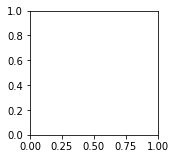

In [ ]:
from scipy.ndimage import zoom
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

X = pickle.load(open("X.pkl", "rb"))

scale = 224 / 7
plt.figure(figsize=(16, 16))
for i in range(36):
    plt.subplot(6, 6, i + 1)
    plt.imshow(X[0])
    plt.imshow(zoom(conv[0, :,:,i], zoom=(scale, scale)), cmap='jet', alpha=0.3)

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_8[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

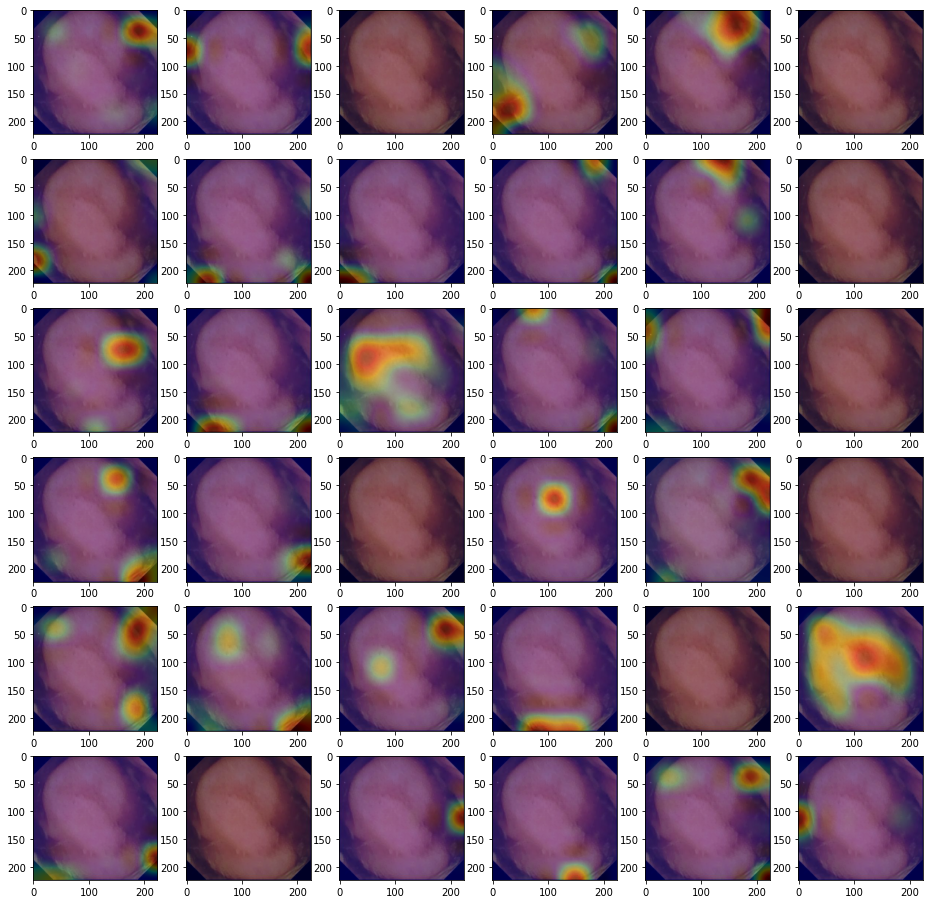

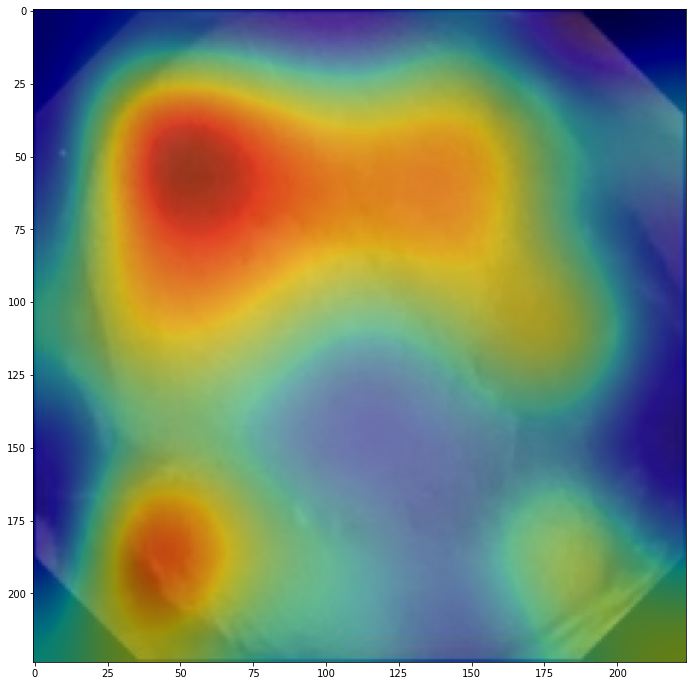

In [ ]:
from tensorflow.keras.applications import ResNet50
res_model = ResNet50()
res_model.summary()


import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
img = cv2.imread('/content/drive/MyDrive/Capsule Endoscopy/labelled_images/Polyp/131368cc17e44240_28955.jpg')
img = cv2.resize(img, [224, 224])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
X = np.expand_dims(img, axis=0).astype(np.float32)
X = preprocess_input(X)

from tensorflow.keras.models import Model
conv_output = res_model.get_layer("conv5_block3_out").output
pred_output = res_model.get_layer("predictions").output
model = Model(res_model.input, outputs=[conv_output, pred_output])

conv, pred = model.predict(X)
decode_predictions(pred)

scale = 224 / 7
plt.figure(figsize=(16, 16))
for i in range(36):
    plt.subplot(6, 6, i + 1)
    plt.imshow(img)
    plt.imshow(zoom(conv[0, :,:,i], zoom=(scale, scale)), cmap='jet', alpha=0.3)

target = np.argmax(pred, axis=1).squeeze()
w, b = model.get_layer("predictions").weights
weights = w[:, target].numpy()
heatmap = conv.squeeze() @ weights

scale = 224 / 7
plt.figure(figsize=(12, 12))
plt.imshow(img)
plt.imshow(zoom(heatmap, zoom=(scale, scale)), cmap='jet', alpha=0.5)



In [ ]:
print(len(training_data))
training_data = np.array(training_data)
categories = np.array(class_nums)


print(training_data.shape)
print(categories.shape)
print(np.unique(categories))

47473
(47473, 50, 50, 3)
(47473,)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]


Logistic Regression

In [ ]:
import numpy as np

training_data3 = training_data

training_data3 = np.array(training_data)
categories = np.array(class_nums)

training_data3 = np.reshape(training_data3, (training_data3.shape[0], -1))

In [ ]:
training_data3.shape

(47473, 7500)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, x_test, y_train, y_test = train_test_split(training_data3, categories, test_size=0.2)

In [ ]:
print(X_train.shape)
print(y_train.shape)

(37978, 7500)
(37978,)


In [ ]:
from sklearn import svm

model = svm.SVC(kernel='linear')
model.fit(X_train, y_train)
y_pred = model.predict(x_test)

from sklearn import metrics

print(metrics.accuracy_score(y_test, y_pred))

In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(class_weight="balanced")
model.fit(X_train, y_train)
print(model.score(x_test, y_test))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


0.45044760400210637
